# Temperature-forecasting problem
***

In [24]:
import os

data_dir = 'jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')
f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [25]:
import numpy as np
float_data = np.zeros((len(lines),len(header)-1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i,:] = values

In [26]:
float_data.shape

(420451, 14)

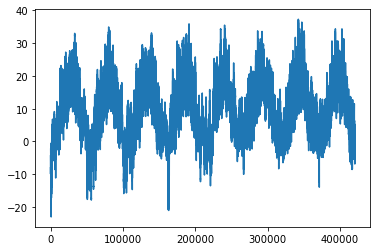

In [27]:
from matplotlib import pyplot as plt 
temp = float_data[:, 1] # temperature (in degrees Celsius) 
plt.plot(range(len(temp)), temp)

In [28]:
mean = float_data[:200000].mean(axis = 0)
float_data -= mean 
std = float_data[:200000].std(axis = 0)
float_data/=std

- data - the original array
- lookback - How many timesteps back the input data should go
- delay - How many timesteps in the future the target should be 
- min_index and max_index - Indices in the data array that delimit which timesteps to draw from. This is useful for keeping a segment of the data for validation and another for testing.
- shuffle - Whether to shuffle the samples or draw them in chrinilogical order.
- batch_size - The number of samples per batch.
- step - The period, in timesteps, at which you sample data. You'll set it to 6 in order to draw one data point every hour.

In [29]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [30]:


lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size



Naive prediction

In [31]:
# def evaluate_naive_method(): 
#     batch_maes = [] 
#     for step in range(val_steps): 
#         samples, targets = next(val_gen) 
#         preds = samples[:, -1, 1] 
#         mae = np.mean(np.abs(preds - targets)) 
#         batch_maes.append(mae) 
#     print(np.mean(batch_maes)) 

# evaluate_naive_method()

In [32]:
import tensorflow as tf
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 10s 19ms/step - loss: 1.8444 - val_loss: 0.6907
Epoch 2/20
500/500 [==============================] - 10s 20ms/step - loss: 0.6017 - val_loss: 0.3503
Epoch 3/20
500/500 [==============================] - 9s 18ms/step - loss: 0.3058 - val_loss: 0.3094
Epoch 4/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2733 - val_loss: 0.2998
Epoch 5/20
500/500 [==============================] - 9s 19ms/step - loss: 0.2576 - val_loss: 0.3237
Epoch 6/20
500/500 [==============================] - 11s 21ms/step - loss: 0.2473 - val_loss: 0.3210
Epoch 7/20
500/500 [==============================] - 10s 19ms/step - loss: 0.2385 - val_loss: 0.3218
Epoch 8/20
500/500 [==============================] - 10s 21ms/step - loss: 0.2308 - val_loss: 0.3544
Epoch 9/20
500/500 [==============================] - 11s 23ms/step - loss: 0.2287 - val_loss: 0.3129
Epoch 10/20
500/500 [==============================] - 11s 23ms/step - loss: 0.2237 -

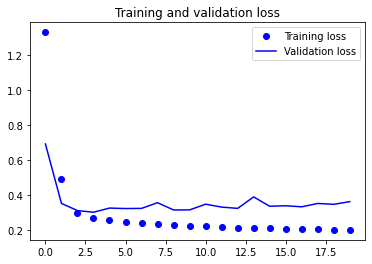

In [33]:


import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()



In [35]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 56s 108ms/step - loss: 0.3770 - val_loss: 0.2768
Epoch 2/20
500/500 [==============================] - 53s 106ms/step - loss: 0.2845 - val_loss: 0.2668
Epoch 3/20
500/500 [==============================] - 53s 107ms/step - loss: 0.2818 - val_loss: 0.2666
Epoch 4/20
500/500 [==============================] - ETA: 0s - loss: 0.2756

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()